<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/Revnb_75_25_Update_H1_T1_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [24]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [25]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

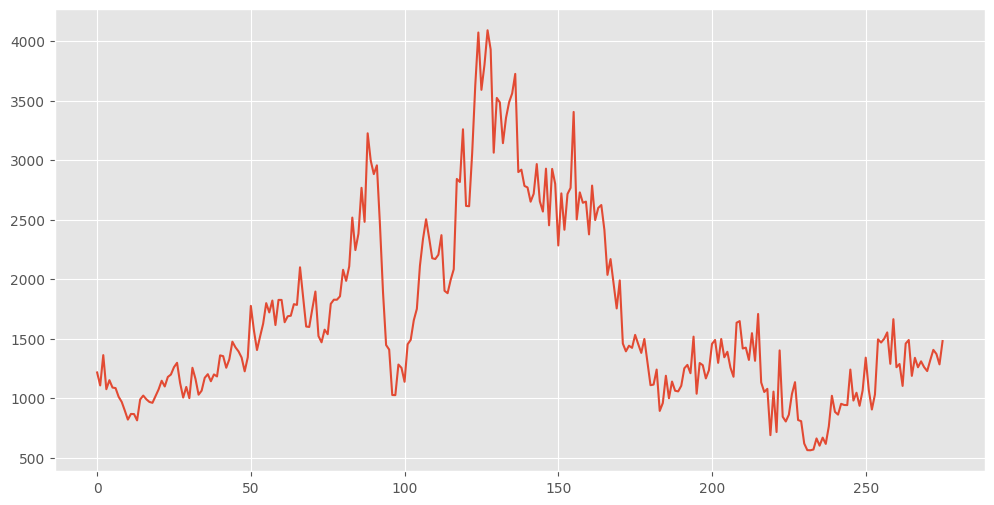

In [26]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [27]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 207
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [28]:
time_steps = 1
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [29]:
ytest = test
ytrain = train

In [30]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [31]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [32]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (206, 1, 1)
y_train.shape:  (206, 1)
X_test.shape:  (69, 1, 1)
y_test.shape:  (69, 1)


In [33]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [34]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [35]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [36]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-13 08:19:04,103] A new study created in memory with name: no-name-f15d32ef-9c48-43c5-ad70-f8480059f3d2


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
Fold 1: MSE = 0.0271
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Fold 2: MSE = 0.0910
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 3: MSE = 0.2585
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0690
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2024-08-13 08:19:36,402] Trial 0 finished with value: 0.09172220528125763 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.09172220528125763.


Fold 5: MSE = 0.0130
Average MSE: 0.0917
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 1: MSE = 0.0184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Fold 2: MSE = 0.0205
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0328
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


[I 2024-08-13 08:20:00,408] Trial 1 finished with value: 0.01693706400692463 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.01693706400692463.


Fold 5: MSE = 0.0024
Average MSE: 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Fold 3: MSE = 0.0338
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-13 08:20:20,987] Trial 2 finished with value: 0.013269712217152119 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.013269712217152119.


Fold 5: MSE = 0.0019
Average MSE: 0.0133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0159
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0378
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 3: MSE = 0.1110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 4: MSE = 0.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-08-13 08:20:49,926] Trial 3 finished with value: 0.04176492989063263 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.013269712217152119.


Fold 5: MSE = 0.0242
Average MSE: 0.0418
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Fold 1: MSE = 0.0260
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 2: MSE = 0.0068
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 4: MSE = 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


[I 2024-08-13 08:21:13,503] Trial 4 finished with value: 0.011662615463137627 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0024
Average MSE: 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 2: MSE = 0.0468
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 3: MSE = 0.0825
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 4: MSE = 0.0496
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2024-08-13 08:21:34,514] Trial 5 finished with value: 0.0398450642824173 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0020
Average MSE: 0.0398
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Fold 2: MSE = 0.0262
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.2088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0354
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 08:21:54,210] Trial 6 finished with value: 0.05969364568591118 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0018
Average MSE: 0.0597
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0291
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.0440
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2024-08-13 08:22:15,858] Trial 7 finished with value: 0.021508194506168365 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0020
Average MSE: 0.0215
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0217
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Fold 2: MSE = 0.0464
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 4: MSE = 0.0542
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-13 08:22:36,230] Trial 8 finished with value: 0.02933620475232601 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0075
Average MSE: 0.0293
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0237
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Fold 2: MSE = 0.0558
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Fold 3: MSE = 0.1952
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0324
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-13 08:22:54,013] Trial 9 finished with value: 0.06979987770318985 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0419
Average MSE: 0.0698
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 1: MSE = 0.0561
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0956
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.2497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.1531
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-13 08:23:16,464] Trial 10 finished with value: 0.11143108457326889 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0027
Average MSE: 0.1114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 1: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.0355
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0221
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-08-13 08:23:36,111] Trial 11 finished with value: 0.015527138486504555 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.011662615463137627.


Fold 5: MSE = 0.0025
Average MSE: 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Fold 1: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
Fold 2: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2024-08-13 08:24:07,517] Trial 12 finished with value: 0.009712244383990765 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.009712244383990765.


Fold 5: MSE = 0.0024
Average MSE: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0093
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0123
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


[I 2024-08-13 08:24:31,170] Trial 13 finished with value: 0.009534082375466824 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0026
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
Fold 3: MSE = 0.0129
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 08:24:54,731] Trial 14 finished with value: 0.009838700294494629 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0021
Average MSE: 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0089
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-13 08:25:18,929] Trial 15 finished with value: 0.009658240713179111 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0022
Average MSE: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-13 08:25:42,113] Trial 16 finished with value: 0.01000167429447174 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0027
Average MSE: 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 1: MSE = 0.0763
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 2: MSE = 0.1466
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
Fold 3: MSE = 0.4274
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.2402
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-13 08:25:59,719] Trial 17 finished with value: 0.18076872825622559 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0133
Average MSE: 0.1808
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Fold 1: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 3: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-13 08:26:22,824] Trial 18 finished with value: 0.010775869712233543 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0028
Average MSE: 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Fold 2: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 3: MSE = 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


[I 2024-08-13 08:26:44,079] Trial 19 finished with value: 0.009983706288039684 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0023
Average MSE: 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0383
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0635
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 3: MSE = 0.2018
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Fold 4: MSE = 0.0606
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-13 08:27:01,761] Trial 20 finished with value: 0.07939673215150833 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0328
Average MSE: 0.0794
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0138
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-08-13 08:27:22,941] Trial 21 finished with value: 0.010639454238116741 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0020
Average MSE: 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 1: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 2: MSE = 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2024-08-13 08:27:55,421] Trial 22 finished with value: 0.009558659046888351 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0027
Average MSE: 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 1: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 3: MSE = 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2024-08-13 08:28:19,396] Trial 23 finished with value: 0.009726585820317268 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0021
Average MSE: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 1: MSE = 0.0157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 4: MSE = 0.0090
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 08:28:41,341] Trial 24 finished with value: 0.010413105599582195 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0024
Average MSE: 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 1: MSE = 0.0300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0866
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.2888
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 4: MSE = 0.0829
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-08-13 08:29:02,763] Trial 25 finished with value: 0.09819892793893814 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0027
Average MSE: 0.0982
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0156
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 3: MSE = 0.0121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-13 08:29:25,686] Trial 26 finished with value: 0.009699434041976929 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0024
Average MSE: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 2: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 3: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 4: MSE = 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-13 08:29:47,330] Trial 27 finished with value: 0.011624773032963276 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0024
Average MSE: 0.0116
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0397
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0701
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 3: MSE = 0.2212
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Fold 4: MSE = 0.0646
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-13 08:30:04,912] Trial 28 finished with value: 0.08484183996915817 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0286
Average MSE: 0.0848
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0364
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 3: MSE = 0.0786
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 08:30:25,107] Trial 29 finished with value: 0.028283890336751938 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0022
Average MSE: 0.0283
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0759
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.1699
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.4306
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Fold 4: MSE = 0.2864
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-08-13 08:30:42,612] Trial 30 finished with value: 0.19484463334083557 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0114
Average MSE: 0.1948
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.0133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


[I 2024-08-13 08:31:03,807] Trial 31 finished with value: 0.010003353469073772 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.009534082375466824.


Fold 5: MSE = 0.0024
Average MSE: 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 1: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 08:31:27,468] Trial 32 finished with value: 0.009317398071289062 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0027
Average MSE: 0.0093
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Fold 1: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 2: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 3: MSE = 0.0127
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-13 08:32:00,846] Trial 33 finished with value: 0.009718405082821846 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0021
Average MSE: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 1: MSE = 0.0172
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Fold 2: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2024-08-13 08:32:25,601] Trial 34 finished with value: 0.009658338502049446 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0021
Average MSE: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 3: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


[I 2024-08-13 08:32:48,265] Trial 35 finished with value: 0.009987162426114082 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0027
Average MSE: 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 1: MSE = 0.0242
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0221
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0342
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0090
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 08:33:09,398] Trial 36 finished with value: 0.018491510301828384 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0030
Average MSE: 0.0185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 3: MSE = 0.0430
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 08:33:29,993] Trial 37 finished with value: 0.014493907801806927 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0019
Average MSE: 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0137
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-08-13 08:33:50,391] Trial 38 finished with value: 0.011211142875254154 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0025
Average MSE: 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0394
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0614
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 3: MSE = 0.2166
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0645
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 08:34:11,165] Trial 39 finished with value: 0.07710013538599014 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0036
Average MSE: 0.0771
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0179
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0407
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0870
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 4: MSE = 0.0290
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


[I 2024-08-13 08:34:30,505] Trial 40 finished with value: 0.035314302891492844 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0019
Average MSE: 0.0353
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Fold 3: MSE = 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 08:34:52,543] Trial 41 finished with value: 0.009504204615950584 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0022
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Fold 1: MSE = 0.0175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0082
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 08:35:14,510] Trial 42 finished with value: 0.009770773351192474 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0020
Average MSE: 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0181
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Fold 2: MSE = 0.0073
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0128
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


[I 2024-08-13 08:35:37,427] Trial 43 finished with value: 0.009875694289803505 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0024
Average MSE: 0.0099
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 1: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-13 08:35:59,166] Trial 44 finished with value: 0.010819895192980766 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0025
Average MSE: 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Fold 3: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Fold 4: MSE = 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-08-13 08:36:33,148] Trial 45 finished with value: 0.009996766224503517 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0024
Average MSE: 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Fold 1: MSE = 0.0066
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 2: MSE = 0.0067
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 3: MSE = 0.0264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 4: MSE = 0.0089
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-08-13 08:36:56,740] Trial 46 finished with value: 0.010141835547983646 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0021
Average MSE: 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 1: MSE = 0.0144
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 2: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 3: MSE = 0.0127
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 4: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2024-08-13 08:37:21,859] Trial 47 finished with value: 0.009606354869902134 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0026
Average MSE: 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 2: MSE = 0.0295
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Fold 3: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-13 08:37:43,458] Trial 48 finished with value: 0.014117235317826271 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0024
Average MSE: 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0345
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0718
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 3: MSE = 0.2194
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Fold 4: MSE = 0.0547
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-13 08:38:02,276] Trial 49 finished with value: 0.08265665173530579 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 32 with value: 0.009317398071289062.


Fold 5: MSE = 0.0330
Average MSE: 0.0827
Best parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}
Best value: 0.009317398071289062


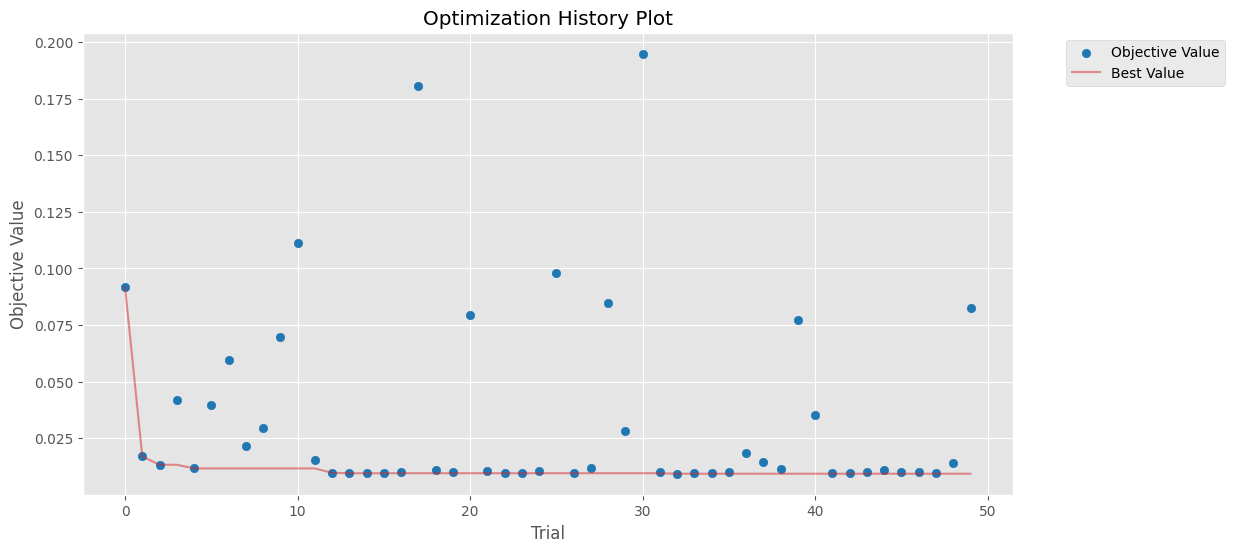

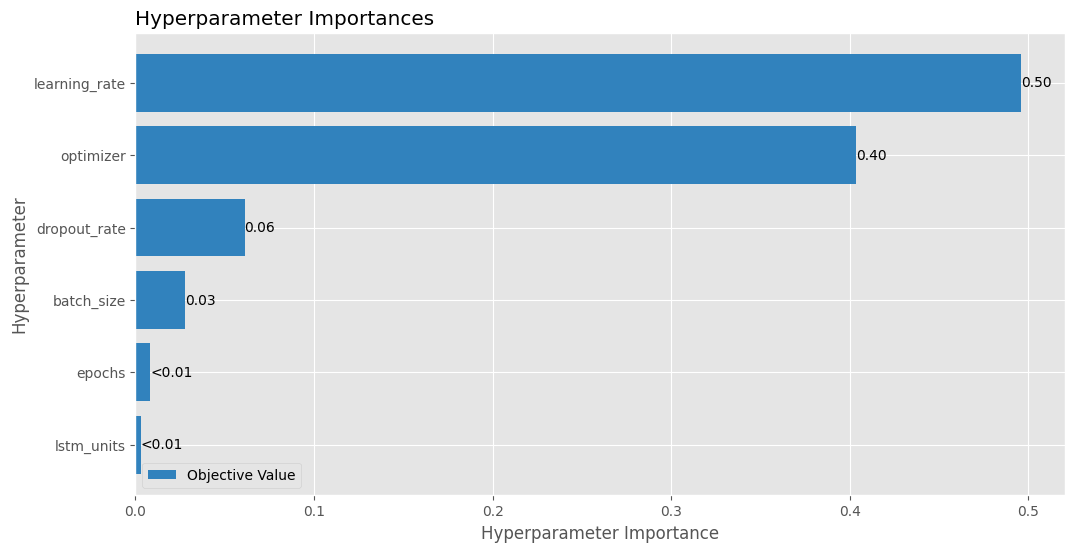

In [37]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [38]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1690 - val_loss: 0.0065
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0525 - val_loss: 0.0372
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0345 - val_loss: 0.0517
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0324 - val_loss: 0.0167
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0254 - val_loss: 0.0065
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0256 - val_loss: 0.0081
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - val_loss: 0.0139
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - val_loss: 0.0105
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113 - val_loss: 0.0041
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - val_loss: 0.00

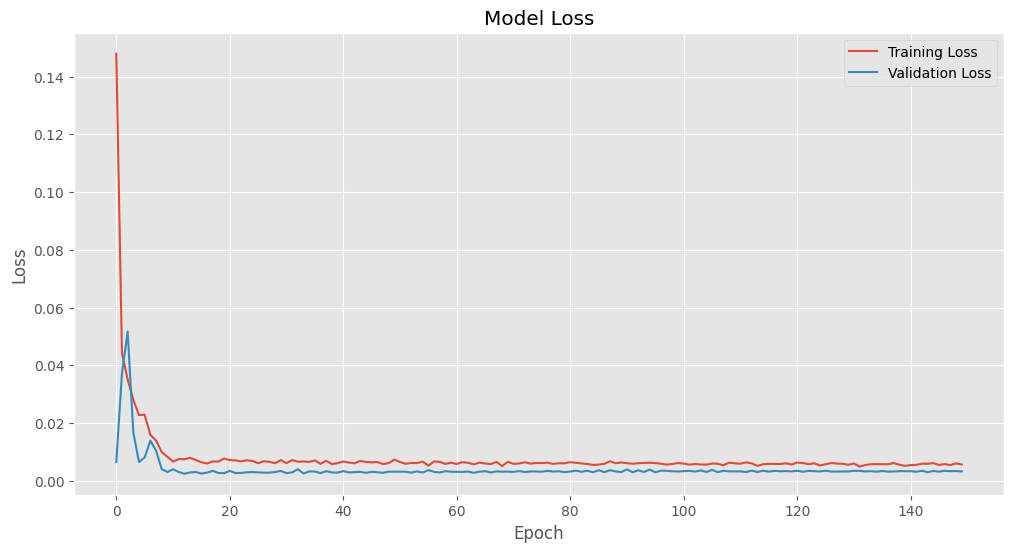

Average Loss: 0.0080


In [39]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [40]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [41]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [42]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [43]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 180.323
Root Mean Square Error: 247.193
Mean Absolute Percentage Error: 9.662%

evaluasi model data test:
Mean Absolute Error: 174.203
Root Mean Square Error: 237.065
Mean Absolute Percentage Error: 16.059%



In [44]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

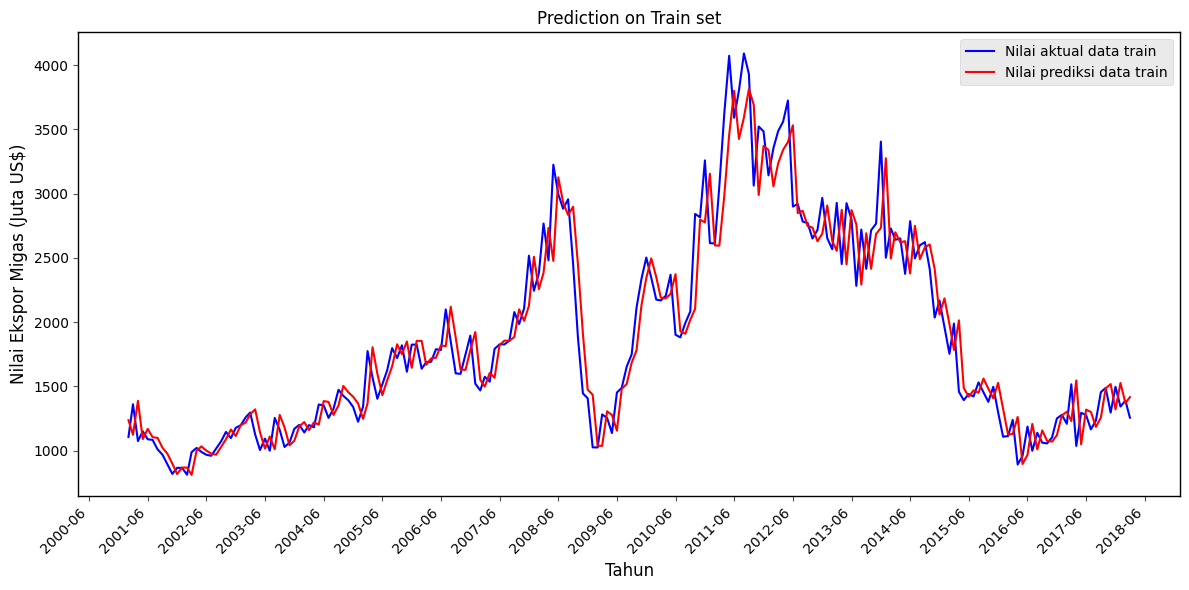

In [46]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

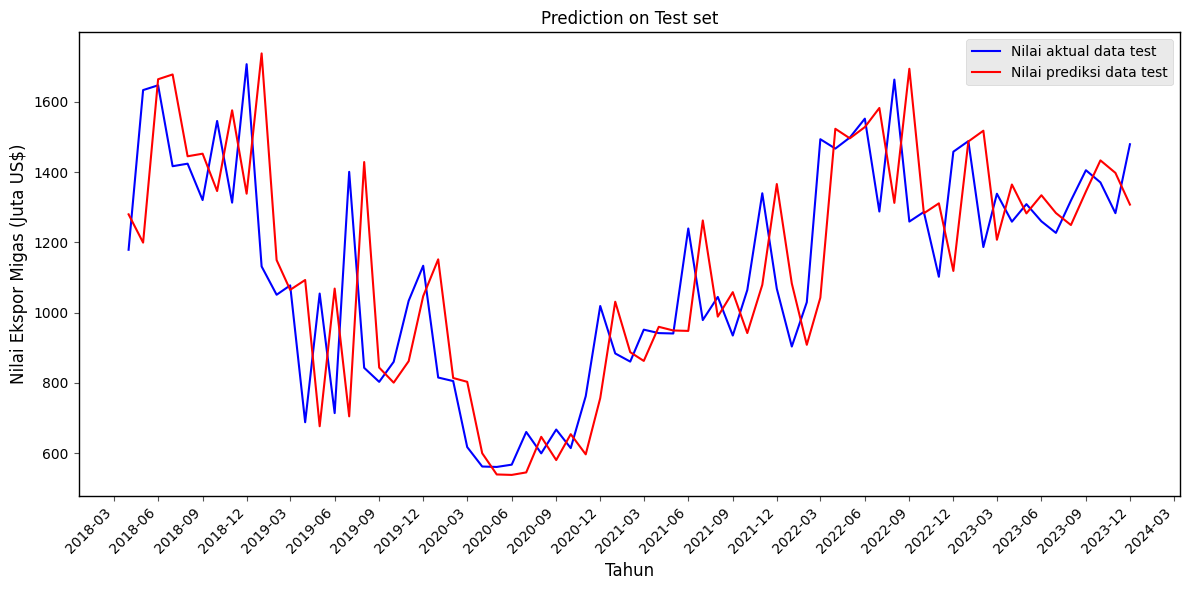

In [47]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

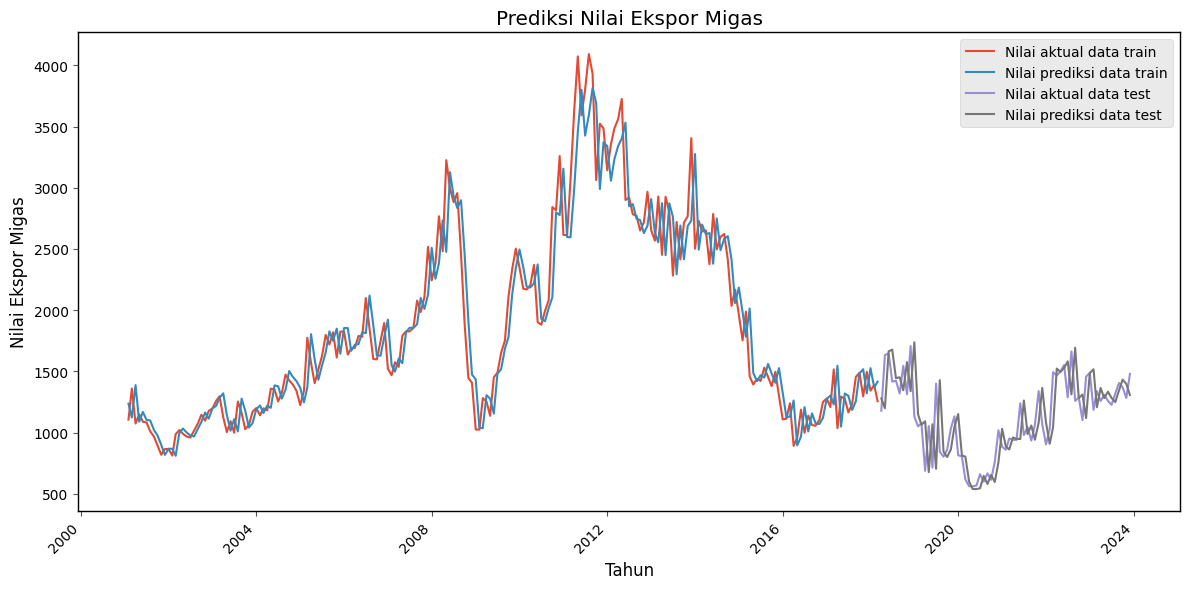

In [48]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1508.460205
1  2024-02-01                     1538.358154
2  2024-03-01                     1568.614136
3  2024-04-01                     1599.144043
4  2024-05-01                     1629.859009
5  2024-06-01                     1660.667847
6  2024-07-01                     1691.476562
7  2024-08-01                     1722.190796
8  2024-09-01                     1752.715942
9  2024-10-01                     1782.959351
10 2024-11-01                     1812

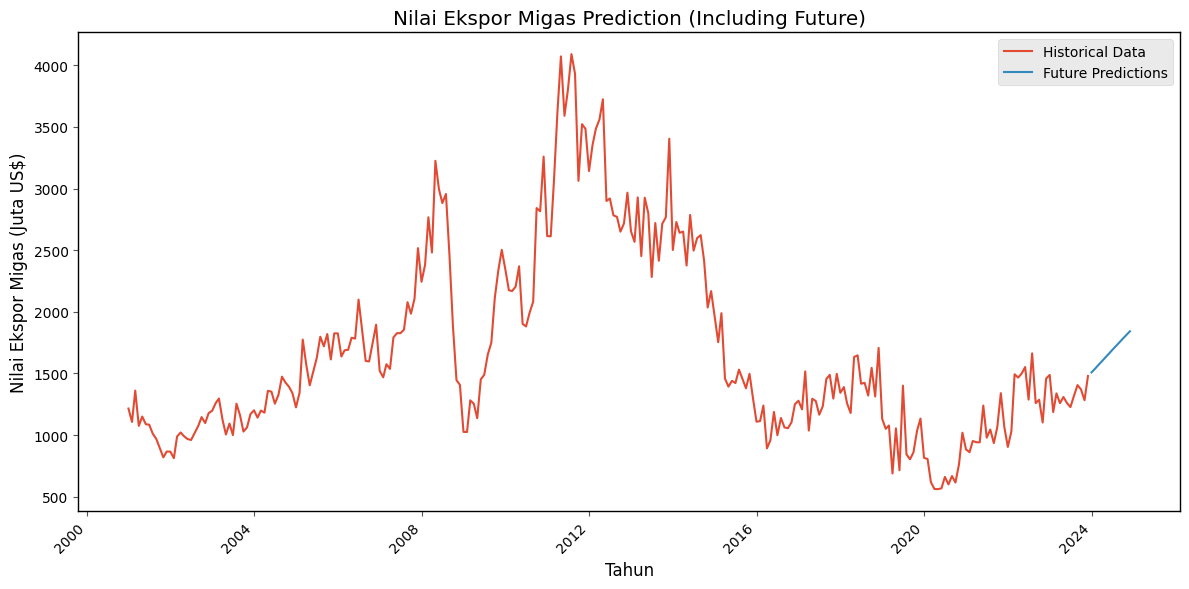

In [50]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


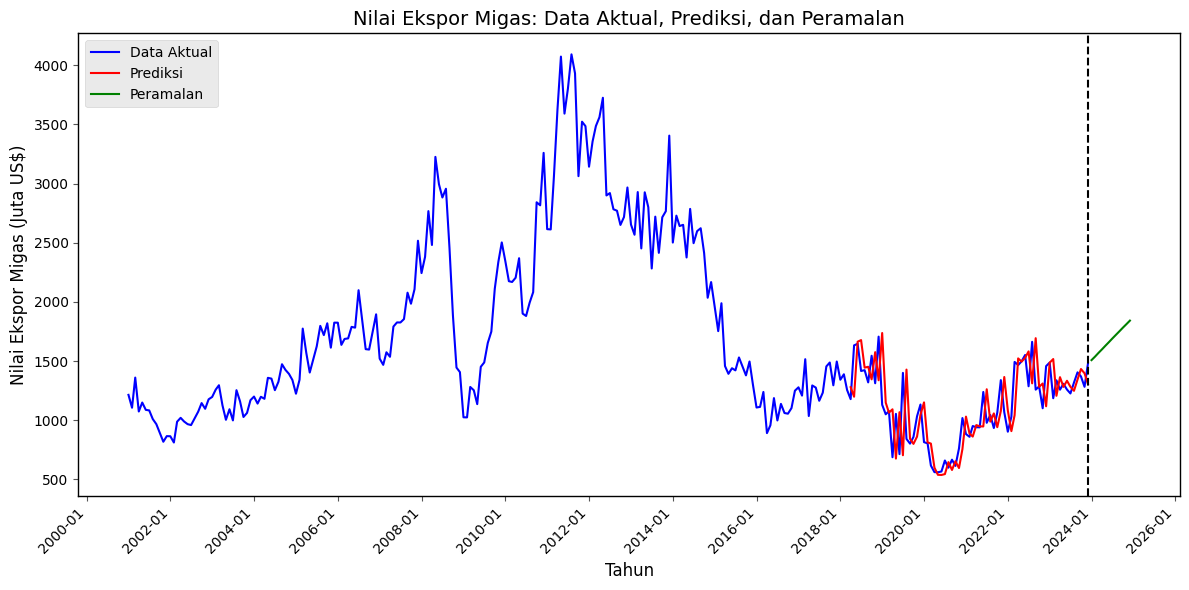

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [53]:
!pip install openpyxl

In [54]:
forecast_df.to_excel('forecast_75:25_h1t1.xlsx', index=False)
from google.colab import files
files.download('forecast_75:25_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_75:25_h1t1.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_75:25_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>